In [ ]:
# !git clone https://github.com/yysijie/st-gcn.git
# %cd st-gcn
# !pip install torch torchvision
# !pip install -r requirements.txt
# !mkdir -p models
# !cp /kaggle/working/st-gcn/models/


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader


file_path = "/kaggle/input/pose-estimate/datasets/preprocessed_dataset.csv"  # Update with your file path
data = pd.read_csv(file_path)


NUM_NODES = 7 
NUM_FEATURES = 2  
NUM_TIMESTEPS = 14 

node_columns = [
    'head_x', 'head_y',
    'beak_base_x', 'beak_base_y',
    'beak_tip_x', 'beak_tip_y',
    'neck_x', 'neck_y',
    'body1_x', 'body1_y',
    'body2_x', 'body2_y',
    'tail_base_x', 'tail_base_y',
]


adjacency_matrix = np.array([
    [0, 1, 0, 1, 0, 0, 0],  # head
    [1, 0, 1, 0, 0, 0, 0],  # beak_base
    [0, 1, 0, 0, 0, 0, 0],  # beak_tip
    [1, 0, 0, 0, 1, 0, 0],  # neck
    [0, 0, 0, 1, 0, 1, 0],  # body1
    [0, 0, 0, 0, 1, 0, 1],  # body2
    [0, 0, 0, 0, 0, 1, 0],  # tail_base
], dtype=np.float32)


In [2]:
data.head()

,behavior,image_id,image_file,head_x,head_y,beak_base_x,beak_base_y,beak_tip_x,beak_tip_y,neck_x,neck_y,body1_x,body1_y,body2_x,body2_y,tail_base_x,tail_base_y
0,nesting,n_001,59-20151230231705-00.jpg,19.234443,92.112384,41.246921,134.089668,39.711167,149.447212,61.211727,86.993203,79.640779,136.137341,123.153818,131.530078,176.393301,7.133978
1,nesting,n_001,59-20151230231706-00.jpg,12.579507,49.111263,43.806512,116.684453,55.580628,136.137341,70.426253,83.921694,83.736124,139.208850,145.166297,131.018160,164.619185,5.086305
2,nesting,n_001,59-20151230231714-00.jpg,24.865542,28.634538,38.175412,83.921694,35.615822,99.279237,61.211727,54.742362,86.295715,137.161177,139.535198,132.553914,193.286599,5.086305
3,nesting,n_001,59-20151230231720-00.jpg,23.841705,105.934174,38.175412,120.267882,42.270757,127.946653,49.949529,112.589110,73.497762,132.553916,111.379702,121.291718,126.225327,-0.544792
4,nesting,n_001,59-20151230231721-00.jpg,26.913214,101.838830,37.151576,117.708291,44.318430,125.387062,51.997201,109.005683,66.842826,139.720769,104.212848,131.018162,141.070952,3.550553


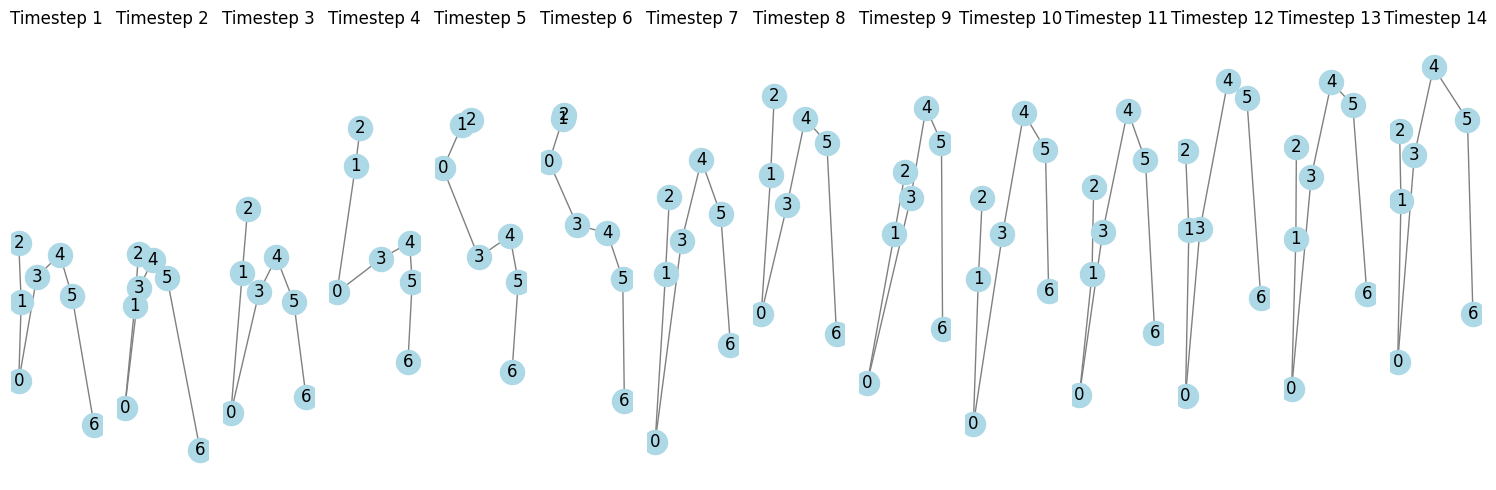

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


image_id = data['image_id'].unique()[3]  # Replace with desired image_id
subset = data[data['image_id'] == image_id]

# Create a function to plot the graph
def draw_stgcn(data, adjacency_matrix, num_timesteps):
    fig, axes = plt.subplots(1, num_timesteps, figsize=(15, 5), sharey=True)
    for t in range(num_timesteps):
        ax = axes[t]
        
        
        timestep_data = data.iloc[t]
        
       
        node_positions = {
            0: (timestep_data['head_x'], timestep_data['head_y']),
            1: (timestep_data['beak_base_x'], timestep_data['beak_base_y']),
            2: (timestep_data['beak_tip_x'], timestep_data['beak_tip_y']),
            3: (timestep_data['neck_x'], timestep_data['neck_y']),
            4: (timestep_data['body1_x'], timestep_data['body1_y']),
            5: (timestep_data['body2_x'], timestep_data['body2_y']),
            6: (timestep_data['tail_base_x'], timestep_data['tail_base_y']),
        }
        
        G = nx.Graph()
        for i in range(NUM_NODES):
            G.add_node(i, pos=node_positions[i])
            for j in range(NUM_NODES):
                if adjacency_matrix[i, j] == 1:
                    G.add_edge(i, j)
        
       
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300)
        ax.set_title(f'Timestep {t + 1}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


draw_stgcn(subset, adjacency_matrix, NUM_TIMESTEPS)


In [6]:
videos = []
video_labels = []
for image_id, group in data.groupby('image_id'):
    frames = group[node_columns].values.reshape(-1, NUM_NODES, NUM_FEATURES)


    if frames.shape[0] > NUM_TIMESTEPS:
        frames = frames[:NUM_TIMESTEPS]
    elif frames.shape[0] < NUM_TIMESTEPS:
        padding = np.zeros((NUM_TIMESTEPS - frames.shape[0], NUM_NODES, NUM_FEATURES))
        frames = np.concatenate([frames, padding], axis=0)

    videos.append(frames)
    video_labels.append(group['behavior'].iloc[0])  # Ensure 'behavior' column exists


In [7]:

input_tensor = np.array(videos)  
video_labels = np.array(video_labels)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(video_labels)

input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

train_x, val_x, train_y, val_y = train_test_split(input_tensor, labels, test_size=0.2, random_state=42)
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [12]:
train_x[0]

tensor([[[131.3445,   6.1101],
         [106.7724,  41.4325],
         [ 83.2242,  57.3020],
         [121.6181,  73.1714],
         [165.1311, 158.6617],
         [279.8008, 144.3280],
         [354.6081,   2.8534]],

        [[ 86.5750,  28.3153],
         [ 92.8858,  73.1220],
         [ 75.8467,  95.8409],
         [120.0223,  85.7436],
         [162.3047, 157.0557],
         [246.8694, 149.4827],
         [357.9396,  23.2667]],

        [[ 96.6736,  32.3284],
         [ 89.8644,  73.9400],
         [ 78.5158,  91.3411],
         [117.1011,  92.0977],
         [135.2588, 135.9789],
         [226.0476, 154.1367],
         [358.4478,  16.4404]],

        [[103.4828,  23.2496],
         [102.7262,  68.6439],
         [ 80.7856,  84.5320],
         [115.5879, 101.1766],
         [155.6863, 154.8933],
         [226.8042, 150.3538],
         [340.2901,  17.1970]],

        [[101.9696,  26.2759],
         [102.7262,  75.4531],
         [ 83.0553,  86.0451],
         [117.1011, 104.9594],


In [13]:
class GatedActivation(nn.Module):
    def __init__(self, in_channels):
        super(GatedActivation, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.conv_gate = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        gate = self.sigmoid(self.conv_gate(x))
        return self.tanh(x) * gate

In [21]:
class BehaviorAttention(nn.Module):
    def __init__(self, num_nodes, num_features, num_behaviors):
        super(BehaviorAttention, self).__init__()
        self.query = nn.Linear(num_features, num_features, bias=False)
        self.key = nn.Linear(num_features, num_features, bias=False)
        self.value = nn.Linear(num_features, num_features, bias=False)
        self.behavior_embedding = nn.Embedding(num_behaviors, num_features)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, node_features, behavior_index):
        # node_features: (batch_size, num_nodes, num_features)
        # behavior_index: (batch_size,)

        # Behavior embedding: (batch_size, 1, num_features)
        behavior_emb = self.behavior_embedding(behavior_index).unsqueeze(1)

        # Attention computation
        Q = self.query(node_features + behavior_emb)  # Query
        K = self.key(node_features)  # Key
        V = self.value(node_features)  # Value

        # Compute attention scores: (batch_size, num_nodes, num_nodes)
        scores = torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attention_weights = self.softmax(scores)

        # Apply attention: (batch_size, num_nodes, num_features)
        out = torch.bmm(attention_weights, V)
        return out, attention_weights


In [22]:
class STGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, A, num_nodes, num_behaviors, stride=1, residual=True):
        super(STGCNLayer, self).__init__()
        self.num_nodes = num_nodes
        self.attention = BehaviorAttention(num_nodes, in_channels, num_behaviors)
        self.graph_conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, num_nodes), stride=(stride, 1))
        self.temporal_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 1), padding=(1, 0), stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = GatedActivation(out_channels)
        self.residual = residual

        if not residual:
            self.residual_connection = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual_connection = lambda x: x
        else:
            self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1))

    def forward(self, x, behavior_index):
        res = self.residual_connection(x)
        N, C, T, V = x.shape

        # Compute attention-adjusted features
        x = x.permute(0, 2, 3, 1).reshape(-1, V, C)  # (batch_size * T, num_nodes, in_channels)
        x, attention_weights = self.attention(x, behavior_index.repeat(T))  # Apply attention
        x = x.reshape(N, T, V, C).permute(0, 3, 1, 2)  # (N, C, T, V)

        # Apply graph and temporal convolutions
        x = self.graph_conv(x)
        x = self.temporal_conv(x)
        x = self.bn(x)
        x = self.activation(x + res)
        return x


In [23]:
class STGCN(nn.Module):
    def __init__(self, num_classes, A, num_nodes, num_features, num_timesteps, num_behaviors):
        super(STGCN, self).__init__()
        self.data_bn = nn.BatchNorm1d(num_nodes * num_features)
        self.A = torch.tensor(A, dtype=torch.float32, requires_grad=False).unsqueeze(0).unsqueeze(0)

        self.layer1 = STGCNLayer(num_features, 64, self.A, num_nodes, num_behaviors)
        self.layer2 = STGCNLayer(64, 128, self.A, num_nodes, num_behaviors)
        self.layer3 = STGCNLayer(128, 256, self.A, num_nodes, num_behaviors)

        self.fc = nn.Linear(256 * num_timesteps, num_classes)

    def forward(self, x, behavior_index):
        N, T, V, C = x.shape

        # Rearrange and normalize
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(N, C * V, T)
        x = self.data_bn(x)
        x = x.view(N, C, V, T).permute(0, 1, 3, 2)

        # STGCN layers
        x = self.layer1(x, behavior_index)
        x = self.layer2(x, behavior_index)
        x = self.layer3(x, behavior_index)

        # Flatten and classify
        x = x.view(N, -1)
        x = self.fc(x)
        return x


In [17]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_encoder.classes_)
model = STGCN(num_classes, adjacency_matrix, NUM_NODES, NUM_FEATURES, NUM_TIMESTEPS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [25]:
for epoch in range(20):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()


            predictions.extend(predicted.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())


    print(f"Epoch {epoch+1}/{20}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    print("Validation Predictions vs Actuals:")
    for pred, actual in zip(predictions, actuals):
        pred_label = label_encoder.inverse_transform([pred])[0]
        actual_label = label_encoder.inverse_transform([actual])[0]
        print(f"Predicted: {pred_label}, Actual: {actual_label}")

Epoch 1/20, Train Loss: 0.0002, Val Loss: 0.5571, Accuracy: 88.89%
Validation Predictions vs Actuals:
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: nesting, Actual: nesting
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: nesting, Actual: preening
Predicted: preening, Actual: preening
Epoch 2/20, Train Loss: 0.0002, Val Loss: 0.5580, Accuracy: 88.89%
Validation Predictions vs Actuals:
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: nesting, Actual: nesting
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: preening, Actual: preening
Predicted: nesting, Actual: nesting
Predicted: nesting, Actual: preening
Predicted: preening, Actual: preening
Epoch 3/20, Train Loss: 0.0001, Val Loss: 0.5598, Accuracy: 88.89%
Validation Predictions vs Actuals:
Predicted: preening, Actual: